# Baseline model for batch monitoring example

In [2]:
import requests
import datetime
import polars as pl

from evidently import DataDefinition
from evidently import Dataset
from evidently import Report
from evidently.metrics import ValueDrift, DriftedColumnsCount, MissingValueCount

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ImportError: cannot import name 'DataDefinition' from 'evidently' (/workspaces/dandori-project/.venv/lib/python3.12/site-packages/evidently/__init__.py)

In [ ]:
from evidently import __version__
__version__

: 

In [36]:
files = [('green_tripdata_2024-03.parquet', './data'), ('green_tripdata_2024-04.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-04.parquet: 100%|██████████| 1346502/1346502 [00:09<00:00, 135999.39it/s, save to ./data/green_tripdata_2024-04.parquet]


In [37]:
jan_data = pl.read_parquet('data/green_tripdata_2024-03.parquet')

In [38]:
jan_data.describe()

statistic,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
str,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",57457.0,"""57457""","""57457""","""55360""",55360.0,57457.0,57457.0,55360.0,57457.0,57457.0,57457.0,57457.0,57457.0,57457.0,0.0,57457.0,57457.0,55360.0,55353.0,55360.0
"""null_count""",0.0,"""0""","""0""","""2097""",2097.0,0.0,0.0,2097.0,0.0,0.0,0.0,0.0,0.0,0.0,57457.0,0.0,0.0,2097.0,2104.0,2097.0
"""mean""",1.877334,"""2024-03-16 04:02:52.405398""","""2024-03-16 04:21:00.076039""",null,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.57741,2.386255,0.192537,null,0.979378,22.904832,1.321062,1.038047,0.73773
"""std""",0.328056,null,null,null,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,null,0.154253,17.013735,0.497858,0.191311,1.218039
"""min""",1.0,"""2008-12-31 23:02:24""","""2008-12-31 23:02:30""","""N""",1.0,1.0,1.0,0.0,0.0,-295.08,-2.5,-0.5,-1.56,0.0,null,-1.0,-296.08,1.0,1.0,-2.75
"""25%""",2.0,"""2024-03-08 13:53:56""","""2024-03-08 14:13:49""",null,1.0,74.0,74.0,1.0,1.1,9.3,0.0,0.5,0.0,0.0,null,1.0,13.44,1.0,1.0,0.0
"""50%""",2.0,"""2024-03-15 22:49:01""","""2024-03-15 23:09:52""",null,1.0,75.0,138.0,1.0,1.79,13.5,0.0,0.5,2.0,0.0,null,1.0,18.5,1.0,1.0,0.0
"""75%""",2.0,"""2024-03-23 20:11:25""","""2024-03-23 20:34:48""",null,1.0,97.0,220.0,1.0,3.1,19.8,1.0,0.5,3.61,0.0,null,1.0,27.05,2.0,1.0,2.75
"""max""",2.0,"""2024-04-01 00:01:45""","""2024-04-01 16:11:00""","""Y""",99.0,265.0,265.0,9.0,125112.2,841.6,10.0,4.25,150.0,26.76,null,1.0,856.98,5.0,2.0,2.75


In [39]:
jan_data.shape

(57457, 20)

In [40]:
# create target
jan_data = jan_data.with_columns(
    duration_min = (pl.col('lpep_dropoff_datetime') - pl.col('lpep_pickup_datetime')).dt.total_seconds() /60
).filter(
    (pl.col('duration_min') >= 0) &
    (pl.col('duration_min') <= 60) &
    (pl.col('passenger_count') > 0) &
    (pl.col('passenger_count') <= 8)
)

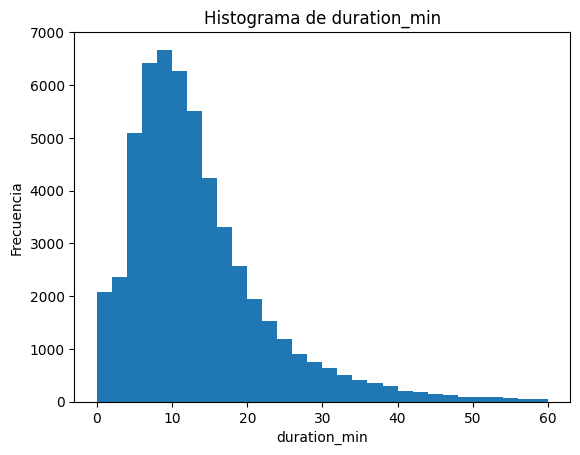

In [41]:
import matplotlib.pyplot as plt

# Supón que quieres graficar la columna 'columna_interes'
values = jan_data['duration_min'].to_numpy()

plt.hist(values, bins=30)
plt.xlabel('duration_min')
plt.ylabel('Frecuencia')
plt.title('Histograma de duration_min')
plt.show()

In [42]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [ ]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [26]:
model = LinearRegression()

In [27]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [29]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data = train_data.with_columns(
    pl.Series(name='prediction', values=train_preds, dtype=pl.Float64)
)

In [30]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data = val_data.with_columns(
    pl.Series(name='prediction', values=val_preds, dtype=pl.Float64)
)

In [32]:
# pandas way
# print(mean_absolute_error(train_data.duration_min, train_data.prediction))
# print(mean_absolute_error(val_data.duration_min, val_data.prediction))
# polars way
print(mean_absolute_error(train_data['duration_min'].to_numpy(), train_data['prediction'].to_numpy()))
print(mean_absolute_error(val_data['duration_min'].to_numpy(), val_data['prediction'].to_numpy()))

3.804665373785062
4.142064073688447


# Dump model and reference data

In [33]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [35]:
val_data.write_parquet('data/reference.parquet')

# Evidently Report

In [46]:
# old evidently code
# from evidently import DataDefinition
# from evidently import Dataset
# from evidently import Report
# from evidently.metrics import ValueDrift, DriftedColumnsCount, MissingValueCount

# new evidently code
from evidently import ColumnMapping
from evidently import Report


ImportError: cannot import name 'Report' from 'evidently' (/workspaces/dandori-project/.venv/lib/python3.12/site-packages/evidently/__init__.py)

In [ ]:
data_definition = DataDefinition(numerical_columns=num_features + ['prediction'], categorical_columns=cat_features)
train_dataset = Dataset.from_pandas(
    train_data,
    data_definition
)

val_dataset = Dataset.from_pandas(
    val_data,
    data_definition
)

In [ ]:
report = Report(metrics=[
    ValueDrift(column='prediction'),
    DriftedColumnsCount(),
    MissingValueCount(column='prediction'),
]
)

In [ ]:
snapshot = report.run(reference_data=train_dataset, current_data=val_dataset)

In [ ]:
snapshot

In [ ]:
result = snapshot.dict()

In [ ]:
result

In [ ]:
#prediction drift
result['metrics'][0]['value']

In [ ]:
#number of drifted columns
result['metrics'][1]['value']['count']

In [ ]:
#share of missing values
result['metrics'][2]['value']['count']

# Evidently Dashboard

In [ ]:
from evidently.presets import DataDriftPreset, DataSummaryPreset

from evidently.ui.workspace import Workspace
from evidently.sdk.panels import *
from evidently.legacy.renderers.html_widgets import WidgetSize

In [ ]:
ws = Workspace("workspace")

In [ ]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

In [ ]:
regular_report = Report(
    metrics=[
        DataSummaryPreset()
    ],
)

data = Dataset.from_pandas(
    val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-28', '2022-01-29', inclusive="left")],
    data_definition=data_definition,
)

regular_snapshot = regular_report.run(current_data=data, timestamp=datetime.datetime(2022,1,28))

regular_snapshot

In [ ]:
ws.add_run(project.id, regular_snapshot)

note: To view a report please run "evidently ui" command in a separate tab in your terminal.

In [ ]:
#configure the dashboard
project.dashboard.add_panel(
    text_panel(title="NYC taxi data dashboard")
)

project.dashboard.add_panel(
    bar_plot_panel(
        title="Inference Count",
        values=[
            PanelMetric(
                metric="RowCount",
                legend="count",
            ),
        ],
        size="half",
    ),
)

project.dashboard.add_panel(
    line_plot_panel(
        title="Number of Missing Values",
        values=[
            PanelMetric(
                metric="DatasetMissingValueCount",
                legend="count"
            ),
        ],
        size="half",
    ),
)

project.save()

To view a dashboard please run "evidently ui" command in a separate tab in your terminal.

In [ ]:
regular_report = Report(
    metrics=[
        DataSummaryPreset()
    ],
)

data = Dataset.from_pandas(
    val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-29', '2022-01-30', inclusive="left")],
    data_definition=data_definition,
)

regular_run = regular_report.run(current_data=data, timestamp=datetime.datetime(2022,1,29))

regular_run

In [ ]:
ws.add_run(project.id, regular_run)